# Notebook 13 Removing Interfaces that are located to close to faults

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functioans to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from online services (WMS, WCS, WFS) or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, choosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems (=GIS) such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook will present how vertices of LineStrings stored as GeoDataFrames can be removed if they are too close to the trace of a fault. The LineStrings in questions usually represent layer boundaries on geological maps. If vertices of these boundaries are too close to faults, the interpolation in `GemPy`or a subsequent uncertainty analysis may not work properly. 

- [What is GemPy?](#gempy)
- [What are Interfaces and Orientations?](#intandor)
- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)
- [Removing Vertices too close to a fault trace](#removingpoints)
- [Removing interfaces points to close to faults (one boundary, one fault)](#removinginterfaces)
- [Removing interfaces points to close to faults (all boundaries, all faults)](#removinginterfaces2)


<a id='gempy'></a>
## What is GemPy?

`GemPy` is a Python-based, **open-source geomodeling library**. It is
capable of constructing complex **3D geological models** of folded
structures, fault networks and unconformities, based on the underlying
powerful **implicit representation** approach. `GemPy` was designed from the
ground up to support easy embedding in probabilistic frameworks for the
uncertainty analysis of subsurface structures.

Check out the documentation either on the main website (https://www.gempy.org/) or the specific docs site (http://docs.gempy.org/).

- GemPy Installation Help: https://docs.gempy.org/installation.html
- GemPy Tutorials: https://docs.gempy.org/tutorials/index.html
- GemPy Examples: https://docs.gempy.org/examples/index.html
- GemPy Repository: https://github.com/cgre-aachen/gempy
- GemPy Tutorial Video: https://youtu.be/n0btC5Zilyc

<a id='intandor'></a>
## What are Interfaces and Orientations?
`GemPy` is using an implicit modeling approach based on the potential field method to create geological models. The only input data required are interfaces (layer boundaries in outcrops or in wells) and orientations (dip and azimuth values of a given orientation). The necessary information for interfaces are the `X`,`Y` and `Z`coordinates as well as the `formation`. Please be aware. that `GemPy` is always referring to the base of a formation! For orientations, `X`,`Y` and `Z`coordinates, the `formation` and `dip`, `azimuth` and `polarity` values are needed. The polarity is usually set to 1. 

<img src="../data/Images/orientations.jpg" width="300">

Image source: Geological Structures: a Practical Introduction - John W.F. Waldron and Morgan Snyder

<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is under constant development and the latest available version can be downloaded at https://github.com/cgre-aachen/gemgis. A pip version can be found at https://pypi.org/project/gemgis/. A dedicated documentation page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load online services as vector and raster data
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data
* `misc.py` - file containing functions for custom tasks 


If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class later in the tutorial, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.8 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the next notebook.

The first step is loading `GemGIS` and the auxiliary libraries `geopandas` and `rasterio` apart from `NumPy` and `Matplotlib`. `GemGIS` will also load `GemPy` the background. If the installation of `GemPy`was not successful, `GemGIS` cannot be used. 

In [1]:
import sys
sys.path.append('../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(gg)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<module 'gemgis' from '../../gemgis\\gemgis\\__init__.py'>


<a id='vreport'></a>
# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Upgrading or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Sat Nov 14 11:05:23 2020 Mitteleuropäische Zeit

                OS : Windows
            CPU(s) : 16
           Machine : AMD64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.19.2
            scooby : 0.5.6
            owslib : 0.20.0
            pandas : 1.1.3
           shapely : 1.7.1
           pyvista : 0.26.1
          rasterio : 1.1.7
         geopandas : 0.8.1
          requests : 2.24.0
             scipy : 1.5.2
           skimage : 0.17.2
        matplotlib : 3.3.2

  Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

<a id='removingvertices'></a>
# Removing Vertices too close to a fault trace

Interface points/vertices of layer boundaries (LineStrings) may be located in close proximity or even fault traces on digital geological maps. Using these interface points for geological modeling with `GemPy` may lead to wrong interpolation results such as that no offset is calculated for layers offset by a fault. In addition, when adding standard deviations to the locations of fault traces on the surface, removing interface points too close to the fault will prevent the calculation of wrong models. 

The interfaces and faults used here are loaded as GeoDataFrames. A buffer can be set around the faults and all vertices of the LineStrings of the layer boundaries within this buffer Polygon will be removed. 

## Loading Interface points and fault data

For this tutorial, we are using layer boundaries and fault traces from the Aachen area, Germany. Both data sets are saved as shape files and will be loaded with `GeoPandas`. The interface data is saved as a Polygon but LineStrings can be extracted from that. 

In [3]:
faults = gpd.read_file('../data/tutorials/tutorial13/GK50_Tektonik.shp')
print(faults.crs)
faults = faults.to_crs('EPSG:4647')
faults.head()

epsg:25832


,ID,NAME,LEGENDE,TYP,BEDECKUNG,HYDRAULIK,AKTIVITAET,BEDEUTUNG,BEARBEITUN,AENDERUNGS,AKTUALISIE,SHAPE_Leng,geometry
0,90006,-,Abschiebung,Abschiebung (su),keine quartäre Bedeckung,nicht bekannt,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,236.48,"LINESTRING (32322728.046 5638651.481, 32322623..."
1,90185,Aachener Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,überregionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,403.92,"LINESTRING (32297864.303 5632557.868, 32297856..."
2,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,184.94,"LINESTRING (32300812.497 5620357.365, 32300932..."
3,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,5738.56,"LINESTRING (32301454.461 5620679.837, 32301589..."
4,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,713.29,"LINESTRING (32306882.447 5625319.830, 32306899..."


In [4]:
interfaces = gpd.read_file('../data/tutorials/tutorial13/GeologicalMapAachen.shp')
print(interfaces.crs)
interfaces.head()

epsg:4647


,OBJECTID,SYSTEM2,SERIE2,SSERIE2,STUFE2,SSTUFE2,SYSTEM1,SERIE1,SSERIE1,STUFE1,...,SGRUPPE,SSYMBOL,EINHEIT1,EINHEIT2,SSY_GSY,GE_GG,GRUTEXT,SHAPE_Leng,SHAPE_Area,geometry
0,131,Devon,Oberdevon,-,Famennium,-,Devonian,Oberdevon,-,Frasnium,...,-,dfrs+f,Frasnes- und Famenne-Schiefer,-,"dfrs+f,T",45403002130.00,Tonstein; untergeordnet Kalkmergel- bis Mergel...,459.12,12043.31,"POLYGON ((32299083.709 5631034.983, 32299164.0..."
1,132,-,-,-,-,-,Neogene,MiozÃ¤n,ObermiozÃ¤n,-,...,-,mii7,Inden-Formation,-,"mii7,s4",7000001110.00,Fein- bis Mittelsand; untergeordnet Schluff un...,4409.72,487296.28,"POLYGON ((32317556.700 5633860.692, 32317497.2..."
2,133,-,-,-,-,-,Neogene,MiozÃ¤n,ObermiozÃ¤n,-,...,-,mii7,Inden-Formation,-,"mii7,s4",7000001110.00,Fein- bis Mittelsand; untergeordnet Schluff un...,7644.70,2347096.98,"POLYGON ((32310428.554 5638385.230, 32310400.4..."
3,134,-,-,-,-,-,Cretaceous,Oberkreide,-,Santonium,...,-,krsah,Aachen-Formation,"Aachen-Formation, Hergenrath-Subformation","krsah,ut",17400001115.00,Schluff und Ton; untergeordnet Fein- bis Mitte...,19078.93,2340702.57,"POLYGON ((32291096.918 5622295.519, 32290989.7..."
4,135,Devon,Oberdevon,-,Famennium,-,Devonian,Mitteldevon,-,Givetium,...,-,dgfk,Massenkalk,-,"dgfk,KD",46800002015.00,Kalkstein und Dolomitstein,4615.89,405124.98,"POLYGON ((32307344.796 5625848.944, 32307389.6..."


## Plotting the Input Data

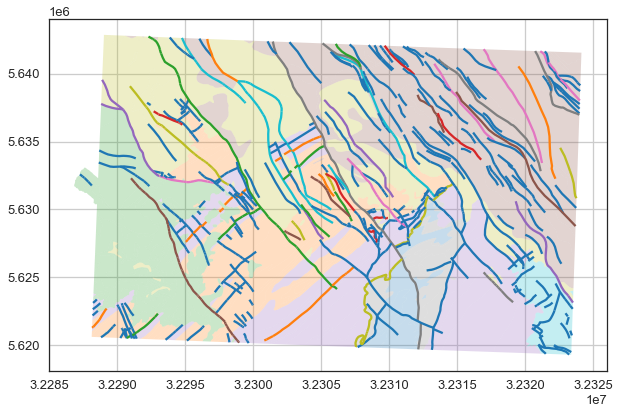

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
faults.plot(ax=ax, aspect='equal', column='NAME')
interfaces.plot(ax=ax, aspect='equal', column = 'SYSTEM1', alpha = 0.25)
plt.grid()

## Convert Polygons to LineStrings

In order for `GemGIS` to work with the layer data, the Polygons need to be transformed into `LineStrings`. The boundaries of the polygons consist of `LineStrings` and `MultiLineStrings`. A dedicated function to convert a `GeoDataFrame` containing `Polygons` into `LineStrings` and `MultiLineStrings` is also part of `GemGIS`.

In [6]:
interfaces.boundary

0      LINESTRING (32299083.709 5631034.983, 32299164...
1      LINESTRING (32317556.700 5633860.692, 32317497...
2      LINESTRING (32310428.554 5638385.230, 32310400...
3      MULTILINESTRING ((32291096.918 5622295.519, 32...
4      LINESTRING (32307344.796 5625848.944, 32307389...
                             ...                        
843    LINESTRING (32314538.180 5638775.131, 32314416...
844    LINESTRING (32317333.245 5635406.896, 32317438...
845    LINESTRING (32324061.121 5638720.353, 32324059...
846    LINESTRING (32292646.291 5642529.199, 32292618...
847    LINESTRING (32301705.663 5641428.471, 32301704...
Length: 848, dtype: geometry

A list of all `LineStrings` is created using list comprehension. 

In [7]:
interfaces_linestrings = [interfaces.boundary[i] for i in range(len(interfaces))]

This list is then used to create a new `GeoDataFrame` containing `LineStrings`.

In [8]:
interfaces_gdf = gpd.GeoDataFrame({'geometry': interfaces_linestrings}, crs=interfaces.crs)
interfaces_gdf

,geometry
0,"LINESTRING (32299083.709 5631034.983, 32299164..."
1,"LINESTRING (32317556.700 5633860.692, 32317497..."
2,"LINESTRING (32310428.554 5638385.230, 32310400..."
3,"MULTILINESTRING ((32291096.918 5622295.519, 32..."
4,"LINESTRING (32307344.796 5625848.944, 32307389..."
...,...
843,"LINESTRING (32314538.180 5638775.131, 32314416..."
844,"LINESTRING (32317333.245 5635406.896, 32317438..."
845,"LINESTRING (32324061.121 5638720.353, 32324059..."
846,"LINESTRING (32292646.291 5642529.199, 32292618..."


## Plotting the LineStrings

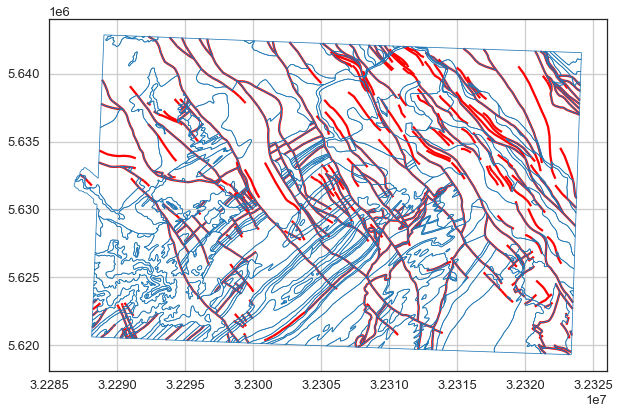

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
faults.plot(ax=ax, aspect='equal', color='red')
interfaces_gdf.plot(ax=ax, aspect='equal', linewidth=0.75)
plt.grid()

## Extracting vertices from LineStrings

`GemGIS` can already work with the created `LineStrings`. For better visualization, the vertices of the `LineStrings` are extracted.

In [10]:
interfaces_gdf_vertices = gg.vector.extract_xy(interfaces_gdf)
interfaces_gdf_vertices.head()

,geometry,X,Y
0,POINT (32299083.709 5631034.983),32299083.71,5631034.98
1,POINT (32299164.005 5630970.066),32299164.01,5630970.07
2,POINT (32299123.225 5630909.550),32299123.23,5630909.55
3,POINT (32299088.346 5630931.022),32299088.35,5630931.02
4,POINT (32298996.618 5630993.458),32298996.62,5630993.46


## Plotting the Vertices

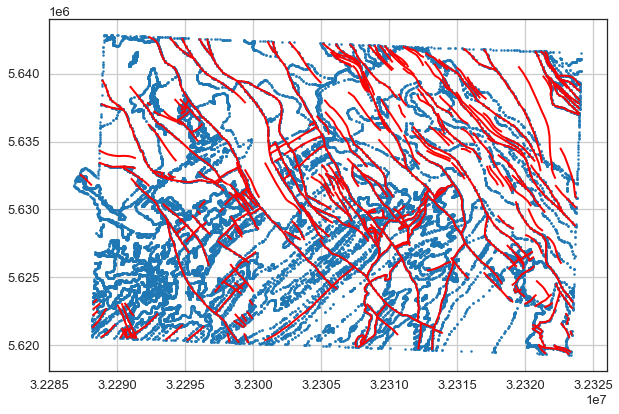

In [11]:
subset= interfaces_gdf_vertices.sample(n=10000, random_state=1)

fig, ax = plt.subplots(figsize=(10,10))
faults.plot(ax=ax, aspect='equal', color='red', linewidth=2)
plt.scatter(interfaces_gdf_vertices.X, interfaces_gdf_vertices.Y, s=4)
plt.grid()

<a id='removinginterfaces'></a>
# Removing interfaces points to close to faults (one boundary, one fault)

Now that the input data has been prepared, the process of removing the interface points is elaborated on in more detail.

The process of removing interfaces is divided into multiple steps:
- Creating a buffer around the fault `LineString`
- Converting single interface and fault `LineStrings` to `GeoDataFrames`
- Using the `within(...)` function of `GeoPandas` to determine if interface points are located within a polygon
- A `GeoDataFrame` is then created for each interface `LineString` for each fault
- All points located too close to a fault trace will be collected and returned
- All points located located outside the buffer zone of the fault are kept

## Creating a buffer around a fault LineString

A buffer around a fault `LineString` can easily be created using the built-in functionality of Shapely. For demonstration purposes, one segment of the `Sandgewand` Fault is chosen. 

In [12]:
sandgewand = faults[(faults['NAME'] == 'Sandgewand') & (faults['SHAPE_Leng'] == 9930.11371649000)]
sandgewand

,ID,NAME,LEGENDE,TYP,BEDECKUNG,HYDRAULIK,AKTIVITAET,BEDEUTUNG,BEARBEITUN,AENDERUNGS,AKTUALISIE,SHAPE_Leng,geometry
782,90105,Sandgewand,Abschiebung,Abschiebung (su),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,überregionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,9930.11,"LINESTRING (32301705.663 5641428.471, 32301705..."


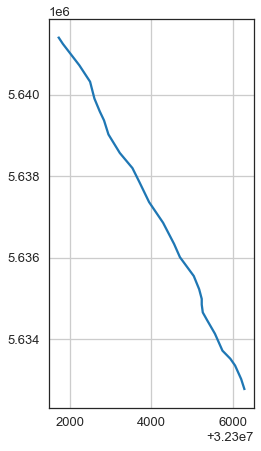

In [13]:
sandgewand.plot()
plt.grid()

## Creating the buffer

In order to create the buffer, the Shapely `LineString` object needs to be accessed. A buffer of 500 units/meters will be set. The resulting object is a `Shapely` `Polygon`.

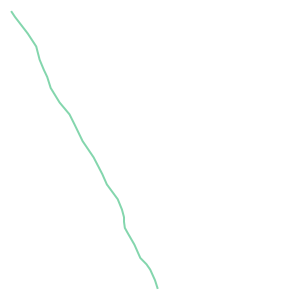

In [14]:
sandgewand.loc[782].geometry

The type of the geometry attribute of the `LineString` is as expected a `Shapely` `LineString`.

In [15]:
type(sandgewand.loc[782].geometry)

shapely.geometry.linestring.LineString

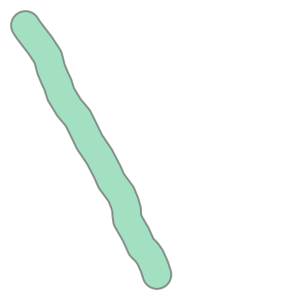

In [16]:
sandgewand_polygon = sandgewand.loc[782].geometry.buffer(500)
sandgewand_polygon

The `Shapely` `Polygon` is converted into a `GeoDataFrame` again.

In [17]:
sandgewand_gdf = gpd.GeoDataFrame({'geometry': [sandgewand_polygon]}, crs=interfaces.crs)
sandgewand_gdf

,geometry
0,"POLYGON ((32302027.118 5640117.688, 32301818.6..."


Plotting the fault trace and the polygon nicely reveals the buffered area.

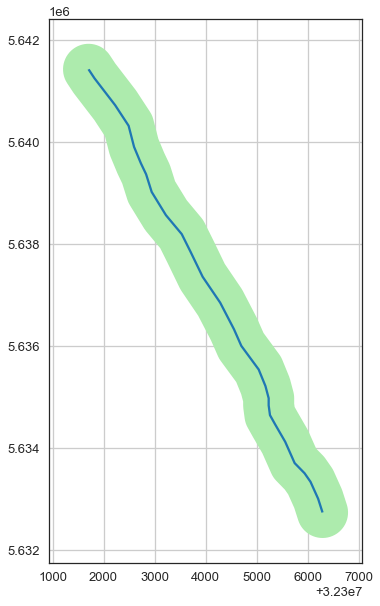

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sandgewand.plot(ax=ax, aspect='equal')
sandgewand_gdf.plot(ax=ax, aspect='equal', color='#adebad')
plt.grid()

## Removing Interface Points of one LineString

This buffer can now be used to remove interface points within this polygon. For demonstration purposes, the layer shown below is used. 

In [19]:
interfaces_gdf.iloc[710]

geometry    LINESTRING (32304353.734 5636448.665, 32304348...
Name: 710, dtype: geometry

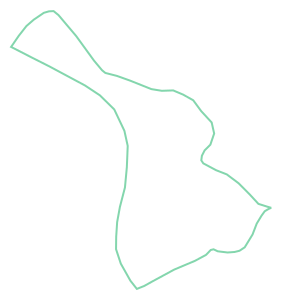

In [20]:
interfaces_gdf.iloc[710].geometry

In [21]:
layer_test = gpd.GeoDataFrame({'geometry': [interfaces_gdf.iloc[710].geometry]}, crs=interfaces.crs)
layer_test

,geometry
0,"LINESTRING (32304353.734 5636448.665, 32304348..."


In [22]:
layer_test_xy = gg.vector.extract_xy(layer_test)
layer_test_xy.head()

,geometry,X,Y
0,POINT (32304353.734 5636448.665),32304353.73,5636448.67
1,POINT (32304348.901 5636447.112),32304348.90,5636447.11
2,POINT (32304334.297 5636442.449),32304334.30,5636442.45
3,POINT (32304323.262 5636437.979),32304323.26,5636437.98
4,POINT (32304311.305 5636431.682),32304311.30,5636431.68


It can be observed, that some of the interface points are located within the buffered area. The interfaces of Polygon are shown in red.

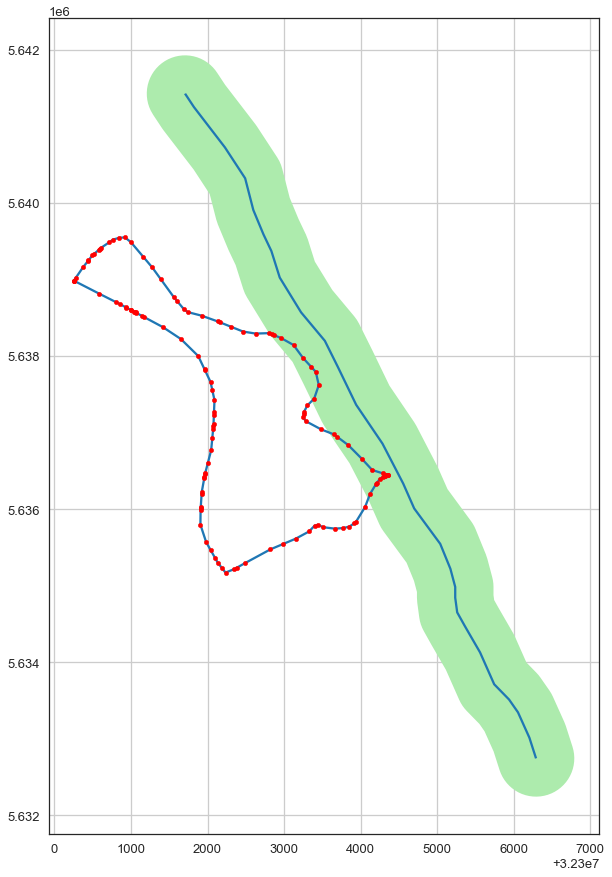

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
sandgewand.plot(ax=ax, aspect='equal')
sandgewand_gdf.plot(ax=ax, aspect='equal', color='#adebad')
layer_test.plot(ax=ax, aspect='equal', zorder=1)
plt.scatter(layer_test_xy.X, layer_test_xy.Y,s=20, color='red')
plt.grid()

We can now use the innermost function of the entire algorithm to remove the vertices of this one `LineString` that are located within the buffered zone of this one fault. The function returns two `LineStrings` or `MultiLineStrings`. One containing the vertices outside the polygon (out) and containing the vertices inside the polygon (in). For this level of the algorithm, we do not need to provide the CRS for the `GeoDataFrames` nor the name of the formation the vertices belong to. At higher levels, these variables are automatically chosen. The most important setting is the radius defining the radius for the buffer zone

In [24]:
vertices_out, vertices_in = gg.vector.remove_interface_vertices_from_fault_linestring(sandgewand.loc[782].geometry, 
                                                                                      interfaces_gdf.iloc[710].geometry, 
                                                                                      radius=500, 
                                                                                      crs=interfaces_gdf.crs,
                                                                                      formation='Formation1')

We can now see, that 97 vertices are located outside the Polygon and 27 are located inside. This can also be confirmed visually.

In [25]:
print(len(vertices_out))
vertices_out.head()

97


,geometry,formation
10,POINT (32304057.408 5636028.505),Formation1
11,POINT (32303933.627 5635826.614),Formation1
12,POINT (32303917.924 5635816.250),Formation1
13,POINT (32303852.039 5635772.762),Formation1
14,POINT (32303775.040 5635753.659),Formation1


In [26]:
print(len(vertices_in))
vertices_in.head()

27


,geometry,formation
0,POINT (32304353.734 5636448.665),Formation1
1,POINT (32304348.901 5636447.112),Formation1
2,POINT (32304334.297 5636442.449),Formation1
3,POINT (32304323.262 5636437.979),Formation1
4,POINT (32304311.305 5636431.682),Formation1


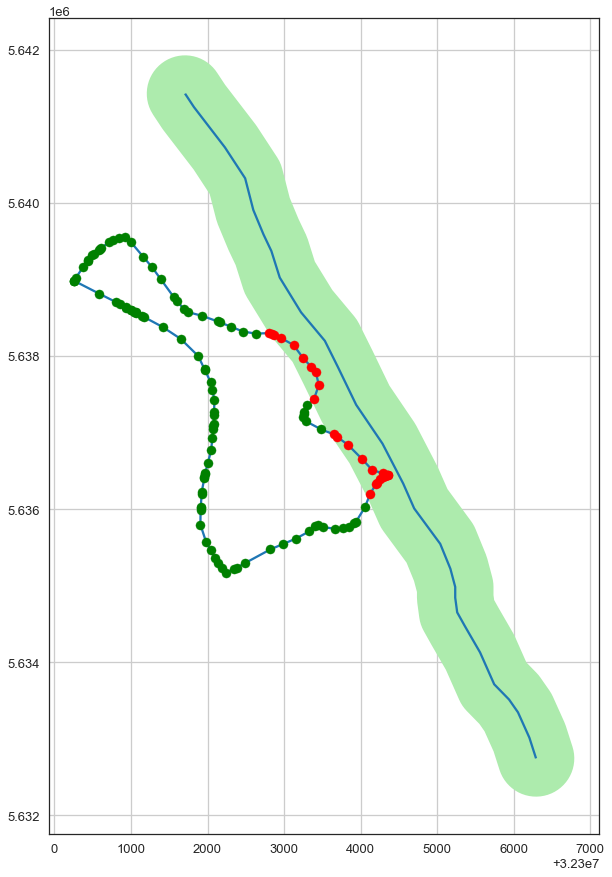

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
sandgewand.plot(ax=ax, aspect='equal')
sandgewand_gdf.plot(ax=ax, aspect='equal', color='#adebad')
layer_test.plot(ax=ax, aspect='equal', zorder=1)
vertices_out.plot(ax=ax, color='green')
vertices_in.plot(ax=ax, color='red')
plt.grid()

<a id='removinginterfaces2'></a>
# Removing interfaces points to close to faults (all boundaries, all faults)

In a last step, it is shown how all interfaces within the buffer zones of all faults are being removed. Only `LineStrings` are chosen for now. `MultiLineString` support will be added soon. An arbitrary formation is given to the dataset as well. 

In [28]:
no_faults = 250
no_boundaries = 50
radius = 250

## Create Buffer for all faults for visualization

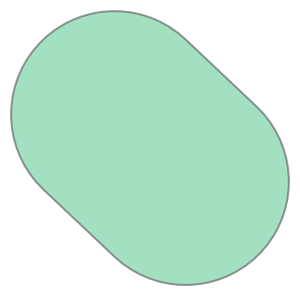

In [29]:
faults_buffer = [faults.loc[:no_faults].loc[i].geometry.buffer(radius) for i in range(no_faults)]
faults_buffer[0]

In [30]:
faults_buffer_gdf = gpd.GeoDataFrame({'geometry': faults_buffer}, crs=interfaces.crs)
faults_buffer_gdf.head()

,geometry
0,"POLYGON ((32322451.571 5638568.791, 32322437.2..."
1,"POLYGON ((32298006.428 5632351.992, 32297925.9..."
2,"POLYGON ((32300830.294 5620639.371, 32300878.8..."
3,"POLYGON ((32301459.441 5620975.994, 32301546.3..."
4,"POLYGON ((32306746.767 5625530.913, 32306904.5..."


## Prepare Interface Points GeoDataFrame

In [31]:
interfaces_gdf = interfaces_gdf[interfaces_gdf.geom_type=='LineString']
interfaces_gdf['formation'] = 'Formation1'
interfaces_gdf = interfaces_gdf.reset_index(drop=True)
interfaces_gdf.head()

,geometry,formation
0,"LINESTRING (32299083.709 5631034.983, 32299164...",Formation1
1,"LINESTRING (32317556.700 5633860.692, 32317497...",Formation1
2,"LINESTRING (32310428.554 5638385.230, 32310400...",Formation1
3,"LINESTRING (32307344.796 5625848.944, 32307389...",Formation1
4,"LINESTRING (32311385.339 5627896.350, 32311386...",Formation1


## Remove Points

<div class="alert alert-block alert-warning">
<b>NB:</b> Despite using list comprehension, the removal of points may be a very time consuming process! A pure shapely implementation will follow.
</div>

In [32]:
vertices_out, vertices_in = gg.vector.remove_vertices_around_faults(faults.loc[:no_faults], 
                                                                    interfaces_gdf.loc[:no_boundaries],
                                                                    radius=radius,
                                                                    )

In [33]:
print(len(vertices_out))
vertices_out.head()

339101


,geometry,formation
0,POINT (32299083.709 5631034.983),Formation1
1,POINT (32299083.709 5631034.983),Formation1
2,POINT (32299083.709 5631034.983),Formation1
3,POINT (32299083.709 5631034.983),Formation1
4,POINT (32299083.709 5631034.983),Formation1


In [34]:
print(len(vertices_in))
vertices_in.head()

1016


,geometry,formation
0,POINT (32305957.849 5624522.667),Formation1
1,POINT (32305859.409 5624437.436),Formation1
2,POINT (32305815.928 5624378.433),Formation1
3,POINT (32305714.934 5624451.934),Formation1
4,POINT (32305692.813 5624474.905),Formation1


## Plotting the result

A designated plotting function is also available in `GemGIS`.

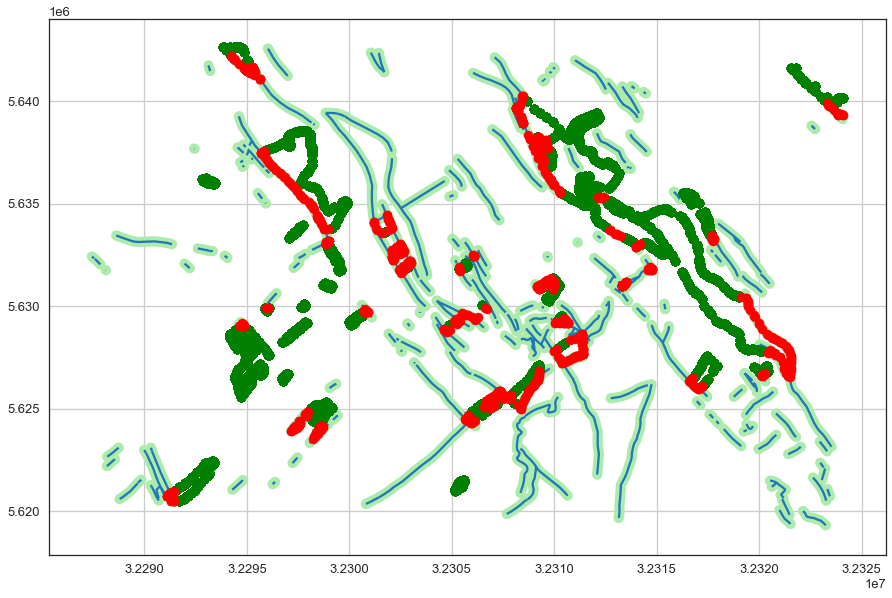

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
faults[:no_faults].plot(ax=ax, aspect='equal')
vertices_out.plot(ax=ax, color='green', zorder=5)
vertices_in.plot(ax=ax, color='red', zorder=5)
faults_buffer_gdf.plot(ax=ax, aspect='equal', color='#adebad', zorder=1)
plt.grid()

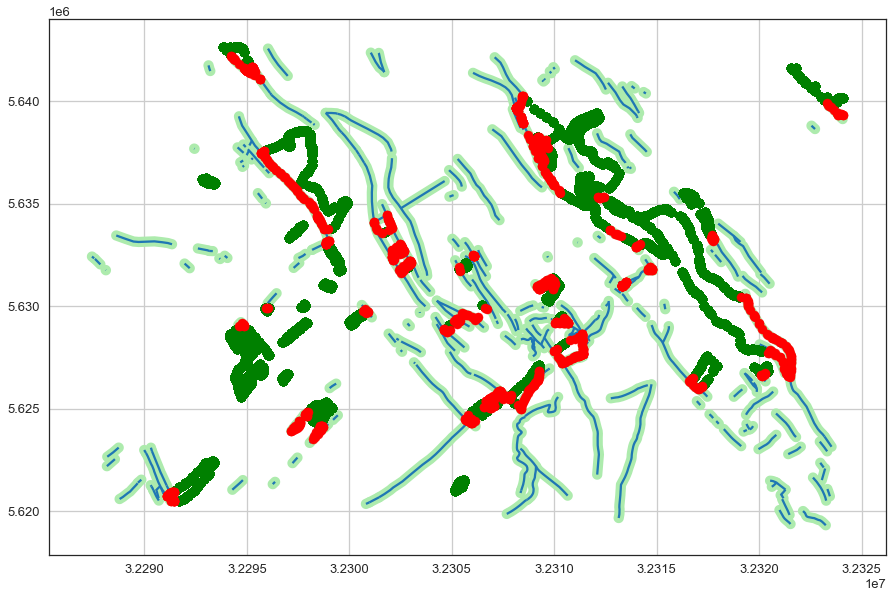

In [36]:
fig, ax = gg.visualization.plot_removed_values(faults.loc[:no_faults], vertices_out, vertices_in, radius)

In [2]:
faults = gpd.read_file('../data/tutorials/tutorial13/GK50_Tektonik.shp')
print(faults.crs)
faults = faults.to_crs('EPSG:4647')
faults.head()

epsg:25832


,ID,NAME,LEGENDE,TYP,BEDECKUNG,HYDRAULIK,AKTIVITAET,BEDEUTUNG,BEARBEITUN,AENDERUNGS,AKTUALISIE,SHAPE_Leng,geometry
0,90006,-,Abschiebung,Abschiebung (su),keine quartäre Bedeckung,nicht bekannt,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,236.48,"LINESTRING (32322728.046 5638651.481, 32322623..."
1,90185,Aachener Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,überregionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,403.92,"LINESTRING (32297864.303 5632557.868, 32297856..."
2,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,184.94,"LINESTRING (32300812.497 5620357.365, 32300932..."
3,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,5738.56,"LINESTRING (32301454.461 5620679.837, 32301589..."
4,90196,Breinigerberg Überschiebung,Auf- oder Überschiebung,Aufschiebung (sa),keine quartäre Bedeckung,hydraulisch wirksam - wasserführend,tektonisch nicht aktiv,lokale bis regionale Bedeutung,2010-07-29,2010-07-29,2019-09-26,713.29,"LINESTRING (32306882.447 5625319.830, 32306899..."


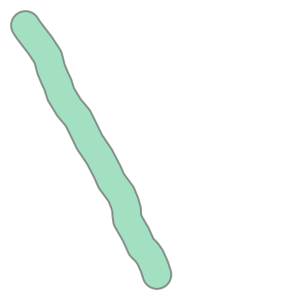

In [25]:
polygon = gg.vector.create_buffer(faults.loc[782].geometry, distance=500)
polygon 

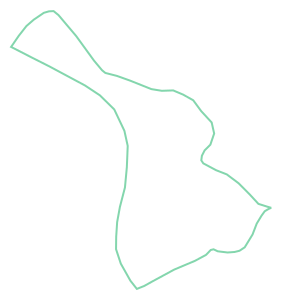

In [26]:
ints = interfaces_gdf.iloc[710].geometry
ints

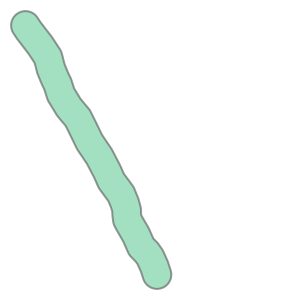

In [27]:
gg.vector.subtract_geom_objects(polygon, ints)

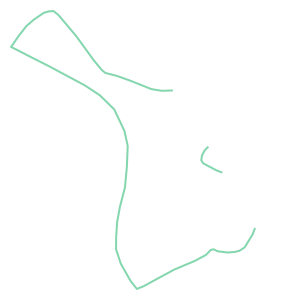

In [28]:
gg.vector.subtract_geom_objects(ints, polygon)

In [29]:
ints2, poly2 = gg.vector.remove_object_from_buffer(faults.loc[782].geometry, ints, 500)

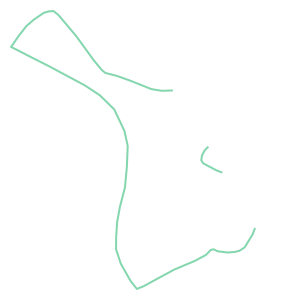

In [30]:
ints2

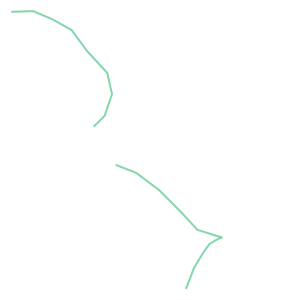

In [31]:
poly2